In [1]:
import numpy as np
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from retrievalnet.evaluation import compute_recall, is_gt_match_2D
from retrievalnet.datasets.nclt import Nclt
from retrievalnet.settings import DATA_PATH, EXPER_PATH
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
def get_data(seq, experiment):
    im_poses = Nclt.get_pose_file(seq)
    descriptors = []
    for t in tqdm(im_poses['time'], leave=False):
        descriptors.append(np.load(
            Path(EXPER_PATH, 'exports', experiment, seq, str(t)+'.npy')))
    return im_poses, np.array(descriptors)
def nclt_recall(ref_seq, query_seqs, experiment,
                distance_thresh=10, angle_thresh=np.pi/2, *arg, **kwarg):
    ref_poses, ref_descriptors = get_data(ref_seq, experiment)
    query_poses, query_descriptors = [], []
    for s in query_seqs:
        poses, descriptors = get_data(s, experiment)
        query_poses.append(poses)
        query_descriptors.append(descriptors)
    query_poses = np.concatenate(query_poses, axis=0)
    query_descriptors = np.concatenate(query_descriptors, axis=0)
    gt_matches = is_gt_match_2D(query_poses, ref_poses, distance_thresh, angle_thresh)
    return compute_recall(ref_descriptors, query_descriptors, gt_matches, *arg, **kwarg)

# Recall

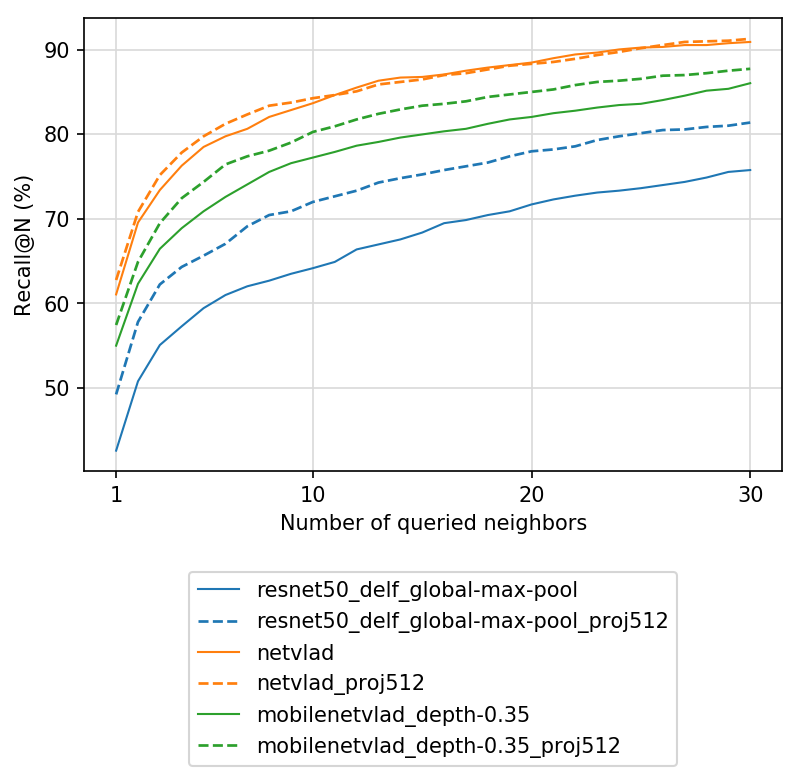

In [4]:
experiments = ['resnet50_delf_global-max-pool', 'netvlad', 'mobilenetvlad_depth-0.35']
ref_seq = '2012-01-08'
query_seqs = ['2013-02-23', '2012-08-20']

plt.figure(dpi=150)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for e, c in tqdm(zip(experiments, colors), leave=True):
    m = nclt_recall(ref_seq, query_seqs, e, max_num_nn=30, pca_dim=0)
    plt.plot(1+np.arange(len(m)), 100*m, label=e, color=c, linewidth=1);
    m = nclt_recall(ref_seq, query_seqs, e, max_num_nn=30, pca_dim=512)
    plt.plot(1+np.arange(len(m)), 100*m, label=e+'_proj512', 
             color=c, linewidth=1.3, linestyle='--');

plt.xticks([1]+np.arange(10, 31, step=10).tolist()); plt.grid(color=[0.85]*3);
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2));
plt.xlabel('Number of queried neighbors'), plt.ylabel('Recall@N (%)');

# NN search run-time, recall, and PCA dimensionality

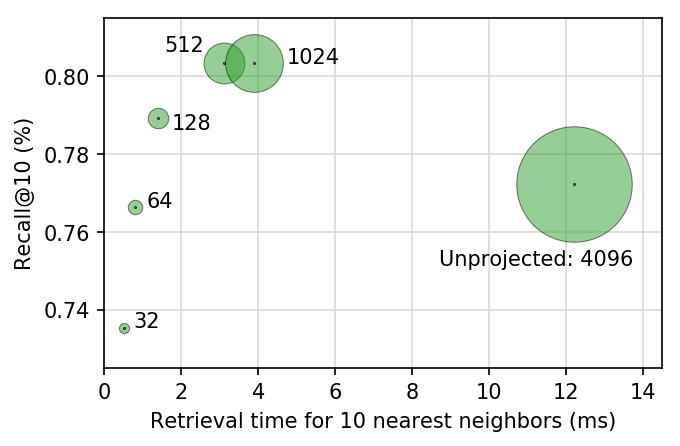

In [5]:
experiment = 'mobilenetvlad_depth-0.35'
ref_seq = '2012-01-08'
query_seqs = ['2013-02-23', '2012-08-20']

dims = [32, 64, 128, 512, 1024, 0]
timings = [0.5, 0.8, 1.4, 3.1, 3.9, 12.2] # as measured on the Jetson
annotations = ['{}'.format(d) for d in dims[:-1]] + ['Unprojected: 4096']
offsets = [(0.25, 0), (0.3, 0), (0.34, -0.003), (-1.55, 0.003), (0.84, 0), (-3.5, -0.021)]

plt.figure(figsize=(4.8, 3.2), dpi=150)
for d, t, a, o in zip(dims, timings, annotations, offsets):
    r = nclt_recall(ref_seq, query_seqs, experiment, max_num_nn=10, pca_dim=d)[-1]
    plt.scatter(t, r, c=colors[2], s=(d if d != 0 else 4096)*0.75, 
                edgecolors='k', linewidths=0.5, zorder=10, alpha=0.5)
    plt.scatter(t, r, marker='.', c='k', zorder=11, s=0.5)
    plt.annotate(a, xy=(t+o[0], r+o[1]))

plt.ylim(0.725, 0.815); plt.xlim(0, 14.5);
plt.grid(color=[0.85]*3); plt.gcf().subplots_adjust(bottom=0.15);
plt.xlabel('Retrieval time for 10 nearest neighbors (ms)'), plt.ylabel('Recall@10 (%)');